In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import visualkeras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

train_df = pd.read_csv("dataset/sign_mnist_train.csv")
test_df = pd.read_csv("dataset/sign_mnist_test.csv")
test = pd.read_csv("dataset/sign_mnist_test.csv")
y = test['label']

## Training

In [2]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [3]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [4]:
x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [5]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False
)

datagen.fit(x_train)

In [6]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)      

In [7]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)
history = model.fit(
    datagen.flow(x_train,y_train, batch_size = 128),
    epochs = 20,
    validation_data=(x_test, y_test),
    callbacks=[learning_rate_reduction]
)
model.save("asl_model.h5")

Epoch 1/20


215/215 [==============================] - 15s 65ms/step - loss: 1.0516 - accuracy: 0.6706 - val_loss: 3.5802 - val_accuracy: 0.0618 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 14s 67ms/step - loss: 0.2283 - accuracy: 0.9246 - val_loss: 1.0147 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 15s 68ms/step - loss: 0.1118 - accuracy: 0.9641 - val_loss: 0.1845 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 15s 69ms/step - loss: 0.0718 - accuracy: 0.9770 - val_loss: 0.0888 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 15s 71ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.0306 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 15s 72ms/step - loss: 0.0371 - accuracy: 0.9886 - val_loss: 0.0212 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 15

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [8]:
print(f"Accuracy of the model is: {model.evaluate(x_test,y_test)[1] * 100}%")

225/225 [==============================] - 1s 5ms/step - loss: 0.0064 - accuracy: 0.9964
Accuracy of the model is: 99.6374785900116%


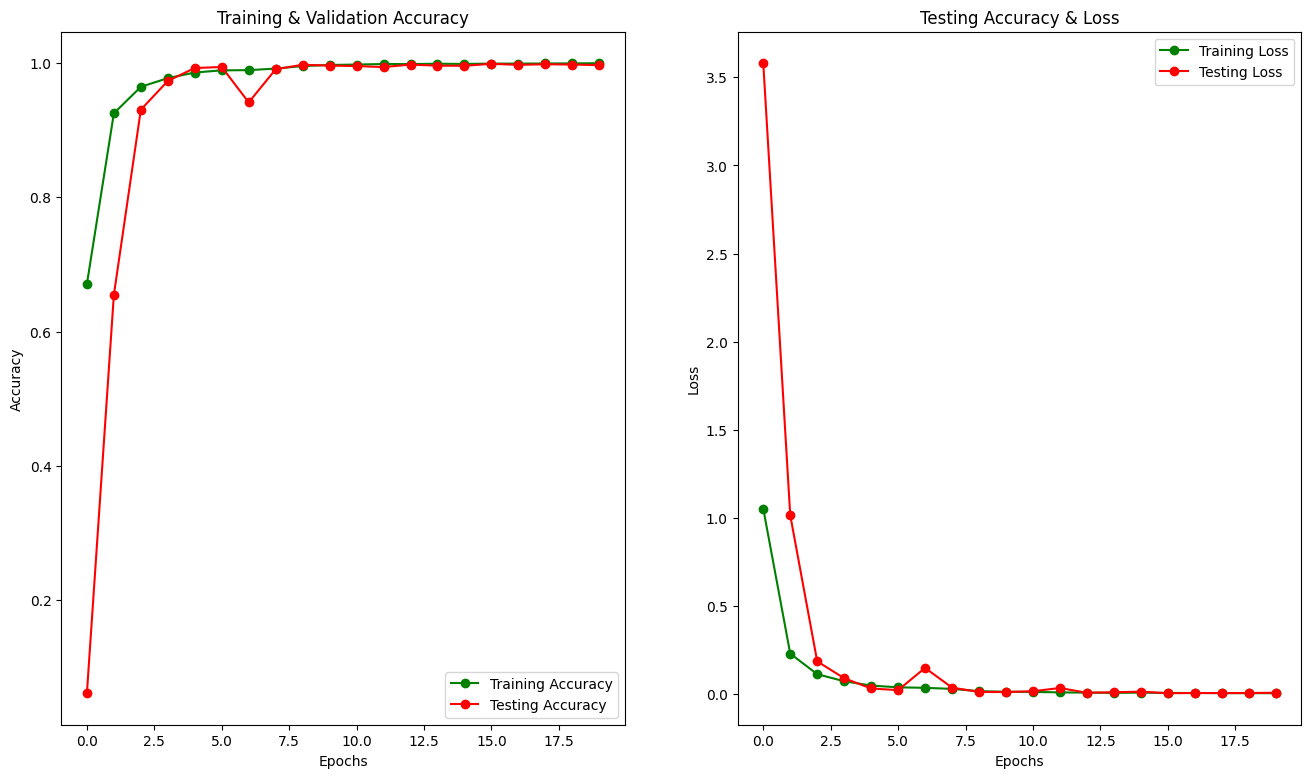

In [9]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss,'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
predict_x = model.predict(x_test)
predictions = np.argmax(predict_x, axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
classes = [f"Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names=classes))

225/225 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       0.98      1.00      0.99       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      0.97      0.98       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00   

<Axes: >

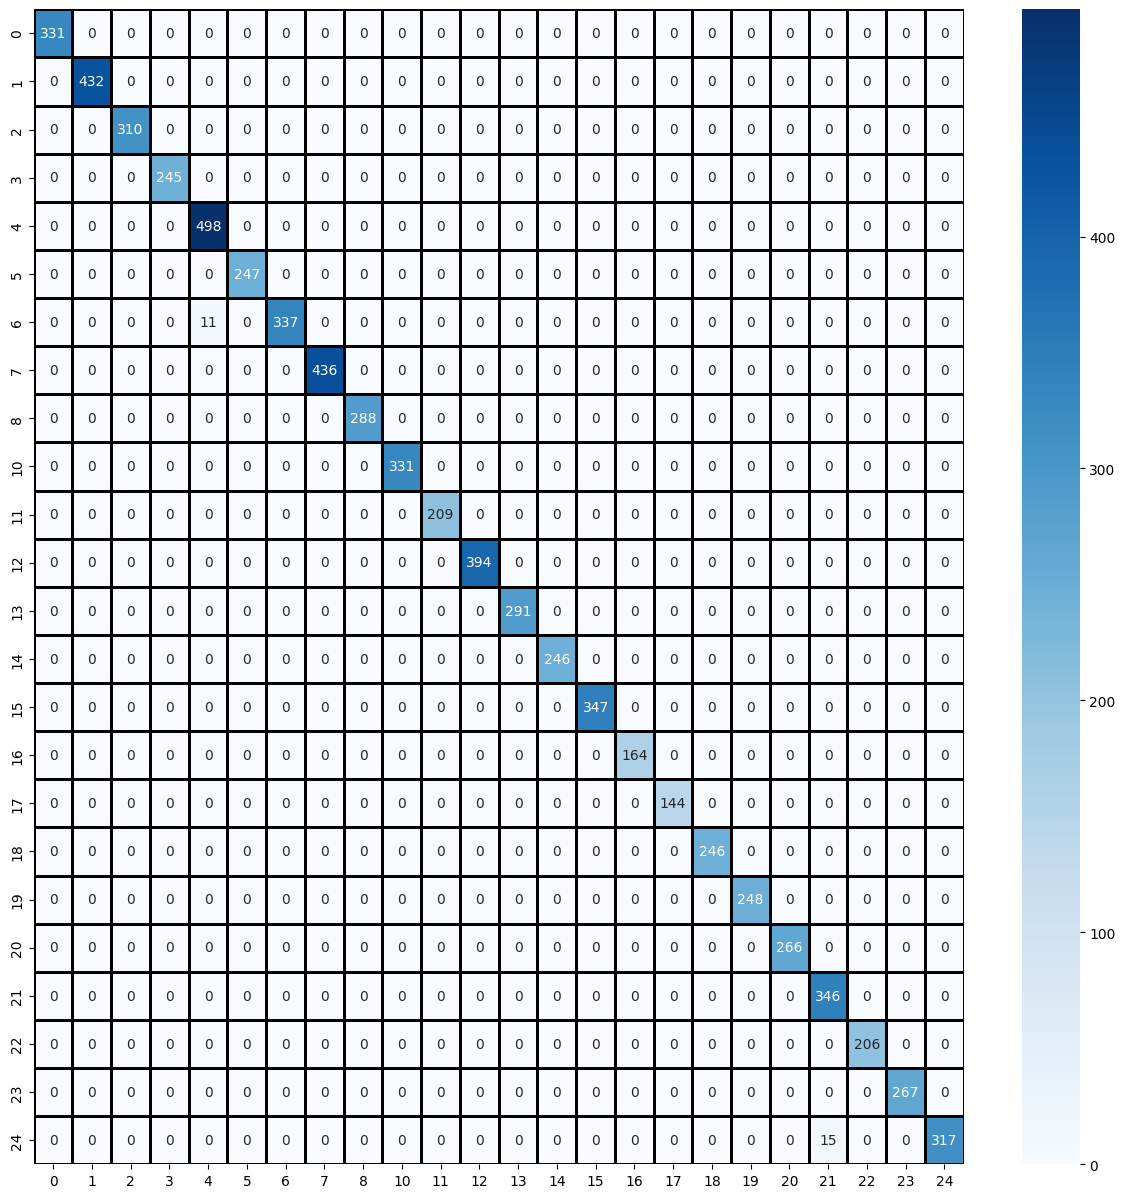

In [20]:
cm = confusion_matrix(y, predictions)
cm = pd.DataFrame(cm, index=[i for i in range(25) if i != 9], columns=[i for i in range(25) if i != 9])
plt.figure(figsize = (15,15))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='')

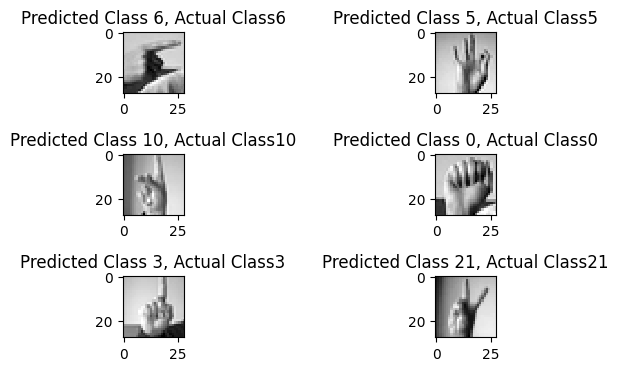

In [15]:
correct = np.nonzero(predictions == y)[0]
i = 0
for c in correct[:6]:
    plt.subplot(4 ,2, i + 1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class{}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

## CNN Visualization

In [16]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    # Get the output shape of the layer
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

c:\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


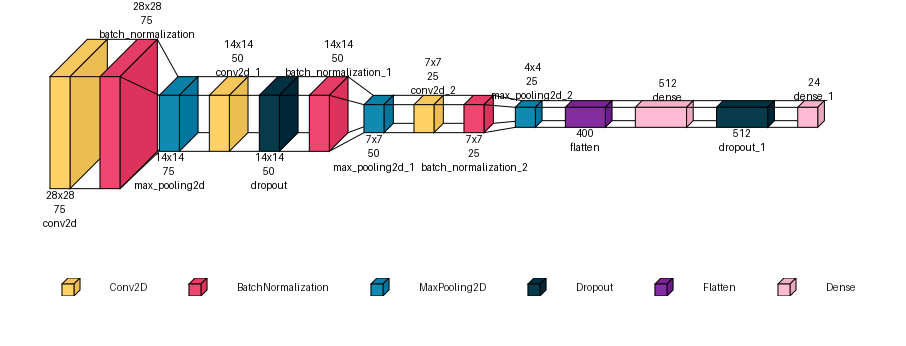

In [17]:
visualkeras.layered_view(model=model, legend=True, spacing=30, text_callable=text_callable, padding=50)

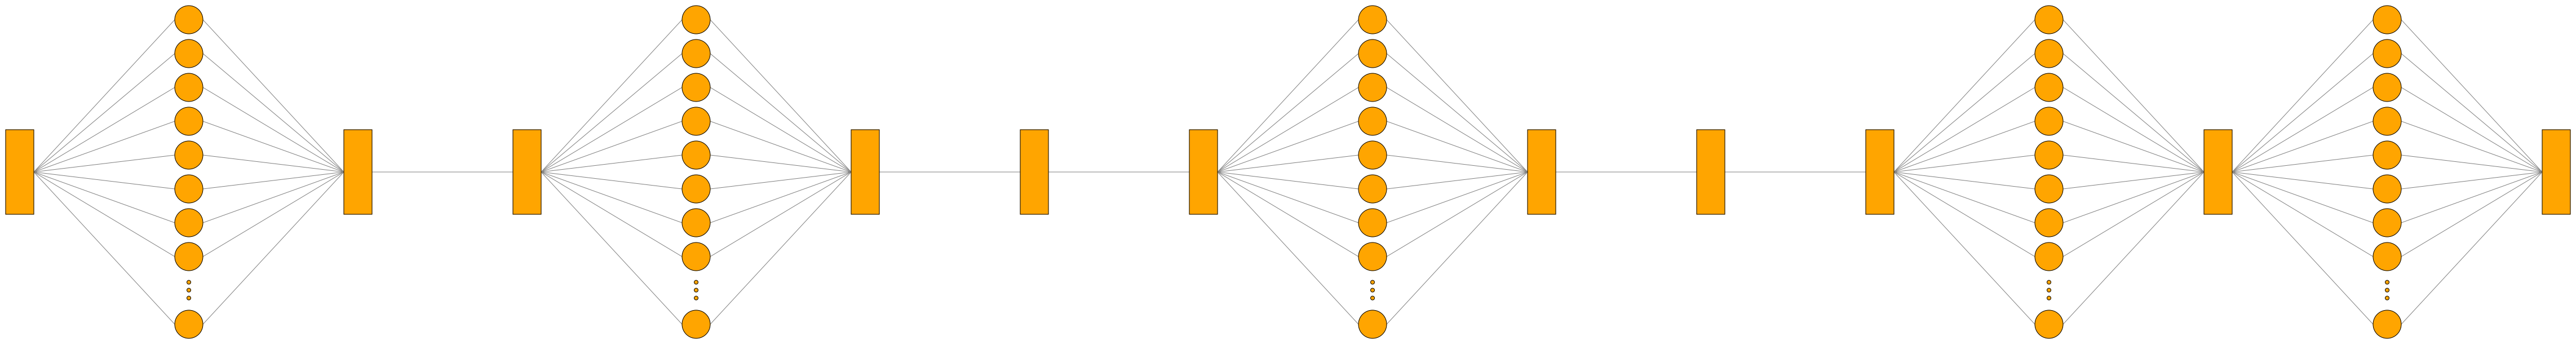

In [18]:
visualkeras.graph_view(model=model)#, legend=True, spacing=30, text_callable=text_callable, padding=50)